In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D,Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Reshape,TimeDistributed,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [ ]:
data=pd.read_csv('datos_limpios.csv')
data.head()

# **Estudio de importancia de variables**
---

In [ ]:
ind_prods=[f'ind_prod{i}' for i in range(1,26)]
data_estudio=data.drop(['cod_persona','mes','fecha1'],axis=1)

In [ ]:
X=data_estudio.drop(ind_prods,axis=1)
y=data_estudio[ind_prods]

### Vamos a emplear un modelo de clasificacion con Boosting para evaluar como considera el propio modelo que es cada variable de importante.

![Modelo Catboost](https://www.researchgate.net/publication/370695897/figure/fig3/AS:11431281170540470@1687832218068/The-flow-diagram-of-the-CatBoost-model.png)


- Comenzamos haciendo la division en muestra de entrenamiento (para entrenar) y muestra de testeo (para evaluar el rendimiento del modelo entrenado)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

In [ ]:
modelos=[]
for idx,prod in enumerate(ind_prods):
    if prod!='ind_prod2': #Hacemos esto porque este producto no lo compra nadie y no vamos a tratar de recomendarlo
        modelo_catboost=CatBoostClassifier(verbose=1000)
        modelo_catboost.fit(X_train,y_train.iloc[:,idx])
        modelos.append(modelo_catboost)
        y_pred = modelo_catboost.predict(X_test)
        # Evaluar la precisión del modelo
        accuracy = accuracy_score(y_test.iloc[:,idx], y_pred)
        print('\n','*'*50)
        print('-'*50,'\nProducto: ',prod)
        print(f'Accuracy: {accuracy}')
        recall = recall_score(y_test.iloc[:,idx], y_pred)
        print(f'Recall: {recall}')
        conf = confusion_matrix(y_test.iloc[:,idx], y_pred)
        print(f'Matriz de confusion: {conf} ','\n')

In [ ]:
data_inicial_mod=pd.DataFrame([modelos[0].feature_importances_],columns=modelos[0].feature_names_)
for model in modelos[1:]:
    data_mod=pd.DataFrame([model.feature_importances_],columns=model.feature_names_)
    data_inicial_mod=pd.concat([data_inicial_mod,data_mod])
data_inicial_mod.median().reset_index().sort_values(0,ascending=False)

Como conclusiones de esta primera prueba:
- Habria que introducir una correccion del desbalanceo de clases ya que hay pocos datos cuando es 1 y muchos cuando es 0 asi que tiende a predecir 0 de mas.
- Habria que probar tratar los datos como series temporales.
- Las siguientes columnas podrian eliminarse ya que el modelo no las considera importantes (Seleccion de variables intrinseca): xti_rel, indext

# **Modelo red Neuronal sin Serie Temporal**
---

In [ ]:
data_rnn=data.drop(['cod_persona','mes','fecha1','xti_rel','indext'],axis=1)
X=data_rnn.drop(ind_prods,axis=1)
y=data_rnn[ind_prods]

Dividimos en muestra de entrenamiento y test.

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

Convertimos los datos a tensores para que los pueda procesar la libreria TensorFlow.

In [ ]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

Creamos la funcion dinamica que nos permite generar muchos modelos simplemente cambiando parametros

In [ ]:
def crear_modelo(input_shape, output_shape, dense_layers=6,dense_layer_units=100, dropout_rate=0.5):
    model = Sequential()
    # Añadir capas Conv2D y MaxPooling2D
    for i in range(dense_layers):
        if i==0:
            input_shape
            model.add(Dense(units=dense_layer_units,activation='relu',input_dim=input_shape))
            model.add(Dropout(dropout_rate))
        else:
            model.add(Dense(units=dense_layer_units,activation='relu'))
            model.add(Dropout(dropout_rate))

    # Capa de salida
    model.add(Dense(output_shape, activation='sigmoid'))
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','categorical_accuracy'])
    
    return model

Creamos un modelo y vemos su arquitectura.

In [ ]:
model=crear_modelo(X_train_tensor.shape[-1],y_test_tensor.shape[1],dense_layers=2,dense_layer_units=20,dropout_rate=.5)
model.summary()

Creamos unos Callbacks para controlar la ejecucion del entrenamiento y entrenamos el modelo

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),  # Parada temprana si la pérdida en validación deja de disminuir
    ModelCheckpoint('modelo_epoch_{epoch:02d}.keras', save_freq='epoch', verbose=1)  # Guardar el modelo en cada época
]
history=model.fit(X_train_tensor,y_train_tensor,epochs=10,batch_size=16,validation_data=(X_test_tensor,y_test_tensor),callbacks=callbacks)

Si evaluamos el modelo con los datos de test.

In [ ]:
loss, recall,accuracy,cat_accuracy = model.evaluate(X_test_tensor, y_test_tensor)
print(f"Loss: {loss}, Accuracy: {accuracy}, Recall: {recall}, Cat Accuracy: {cat_accuracy}")

Vemos que esta red no mejora los resultados iniciales obtenidos con Catboost, probemos a ver si con series temporales mejoramos los resultados.

# **Modelo de red Neuronal con Series Temporales**
---

Lo primero es convertir los datos a secuencias con informacion de varios periodos.

In [ ]:
import numpy as np

def create_sequences(df, cod_persona_col, feature_cols, target_cols, sequence_length):
    sequences = []
    targets = []
    targets_anteriores = []

    personas = df[cod_persona_col].unique()

    # Convertir el DataFrame a un numpy array para operaciones más rápidas
    df_values = df[[cod_persona_col] + feature_cols + target_cols].values
    cod_persona_index = 0  # El índice de cod_persona_col en df_values

    for persona in personas:
        # Filtrar las filas correspondientes a la persona actual
        persona_mask = df_values[:, cod_persona_index] == persona
        persona_df = df_values[persona_mask]
        
        # Si la longitud del DataFrame de la persona es menor que sequence_length, se omite
        if len(persona_df) <= sequence_length:
            continue
        
        for i in range(len(persona_df) - sequence_length):
            sequence = persona_df[i:i+sequence_length, 1:1+len(feature_cols)]
            target = persona_df[i+sequence_length, 1+len(feature_cols):1+len(feature_cols)+len(target_cols)]
            target_anterior = persona_df[i+sequence_length-1, 1+len(feature_cols):1+len(feature_cols)+len(target_cols)]
            sequences.append(sequence)
            targets.append(target)
            targets_anteriores.append(target_anterior)
    
    return np.array(sequences), np.array(targets), np.array(targets_anteriores)

# Definir las columnas de características y de objetivos
feature_cols = [col for col in data.columns if col.find('ind_prod')==-1 and col not in ['cod_persona','mes','fecha1','xti_rel','indext']]
target_cols = [col for col in data.columns if col.find('ind_prod')!=-1 and col.find('ind_prod2')==-1]

# Longitud de la secuencia
sequence_length = 4  # Por ejemplo, secuencias de 5 días

# Crear las secuencias
X_seq, y_seq, y_prev_seq = create_sequences(data, 'cod_persona', feature_cols, target_cols, sequence_length)


Dividimos los datos y convertimos a tensores.

In [ ]:
cutoff = int(len(X) * 0.8)
# Dividir los datos en entrenamiento y prueba manteniendo la temporalidad
X_train, X_test = X_seq[:cutoff], X_seq[cutoff:]
y_train, y_test = y_seq[:cutoff], y_seq[cutoff:]
y_prev_train, y_prev_test = y_prev_seq[:cutoff], y_prev_seq[cutoff:]

X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

y_prev_train_tensor = tf.convert_to_tensor(y_prev_train, dtype=tf.float32)
y_prev_test_tensor = tf.convert_to_tensor(y_prev_test, dtype=tf.float32)

Creamos la funcion para generar modelos de Redes Neuronales Recurrentes.

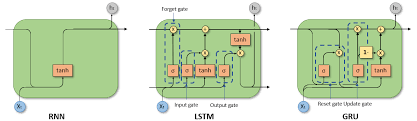

In [ ]:
def crear_modelo_mixto(input_shape, output_shape,  lstm_units=204,dense_units=[], dropout_rate=0.5):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, dropout=dropout_rate, input_shape=input_shape))
    model.add(LSTM(units=lstm_units, return_sequences=False, dropout=dropout_rate, input_shape=input_shape))
    
    # Añadir capas Conv2D y MaxPooling2D
    for i in dense_units:
        model.add(Dense(units=i,activation='relu'))
        model.add(Dropout(dropout_rate))

    # Capa de salida
    model.add(Dense(output_shape, activation='sigmoid'))
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','categorical_accuracy'])
    
    return model

In [ ]:
model=crear_modelo_mixto(X_train_tensor.shape[-2:],y_test_tensor.shape[1],lstm_units=20,dense_units=[40,40,40,40,40,80,60,40],dropout_rate=.5)
model.summary()

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),  # Parada temprana si la pérdida en validación deja de disminuir
    ModelCheckpoint('modelo_epoch_{epoch:02d}.keras', save_freq='epoch', verbose=1)  # Guardar el modelo en cada época
]
history=model.fit(X_train_tensor,y_train_tensor,epochs=2,batch_size=16,validation_data=(X_test_tensor,y_test_tensor),callbacks=callbacks)

- Vemos que no funciona muy bien, hay que tener tambien en cuenta que por cada usuario solo tenemos 16 periodos de informacion, en conclusion, el modelo final sera un Modelo Catboost aplicando el filtrado de productos por segmento y añadiremos pesos a las clases para corregir el desbalanceo.

- Para considerar el comportamiento historico para predecir los productos vamos a añadir las compras del periodo anterior para predecir.

# **Modelo Catboost Final**
---

Primero, obtenemos los productos que si se han comprado por cada segmento.

In [ ]:
diccionario_segmentos=data.groupby(by=['id_segmento'])[ind_prods].sum().T.to_dict()
diccionario_seg_proc={}
for key,value in diccionario_segmentos.items():
    sol=[]
    for prod,res in value.items():
        if res>0:
            sol.append(prod)
    diccionario_seg_proc[key]=sol
diccionario_seg_proc

In [ ]:
#Creamos columnas con un shift sobre el dataset inicial (Idea de competicion Kaggle)
columnas_usar=['pais', 'sexo', 'edad', 'xti_empleado', 'xti_nuevo_cliente',
       'num_antiguedad', 'xti_rel_1mes', 'tip_rel_1mes', 'indresi',
       'des_canal', 'xti_extra', 'cod_provincia', 'xti_actividad_cliente',
       'imp_renta', 'id_segmento', 'mean_engagement','edad_dividida']
DIFF_CONDS = {}
for shift_val in [1]:
    name = 'id_shift_' + str(shift_val)
    data[name] = data['cod_persona'].shift(shift_val).fillna(0).astype(np.int32)
    DIFF_CONDS[shift_val] = ((data['cod_persona'] - data[name]) != 0)
    data.drop(name,axis = 1,inplace=True)

shifted_feature_names = []
for col in columnas_usar + target_cols:
    for shift_val in [1]:
        name = col + '_s_' + str(shift_val)
        data[name] = data[col].shift(shift_val).fillna(0).astype(np.int32)
        data[name][DIFF_CONDS[shift_val]] = 0
        if col in columnas_usar:
            shifted_feature_names.append(name)

In [ ]:
data.head()

Vamos a añadir ademas la informacion del resto del columnas del periodo anterior.

In [ ]:
diff_feautres_s1 = []
for col in columnas_usar:
    name = col + '_s1_diff'
    diff_feautres_s1.append(name)
    data[name] = (data[col] - data[col + '_s_1']).astype(np.int32)

Vamos a crear nuevas columnas (Feature Engineering)

In [ ]:
#Antiguedad minima del usuario
MIN_ANTIGUEDAD_DICT = data.groupby('cod_persona')['num_antiguedad'].min().to_dict()
data['min_antiguedad'] = data['cod_persona'].map(lambda x: MIN_ANTIGUEDAD_DICT[x]).astype(np.int16)

#Antiguedad maxima del usuario
MAX_ANTIGUEDAD_DICT = data.groupby('cod_persona')['num_antiguedad'].max().to_dict()
data['max_antiguedad'] = data['cod_persona'].map(lambda x: MAX_ANTIGUEDAD_DICT[x]).astype(np.int16)

#Edad minima del usuario
MIN_AGE_DICT = data.groupby('cod_persona')['edad'].min().to_dict()
data['min_edad'] = data['cod_persona'].map(lambda x: MIN_AGE_DICT[x]).astype(np.int16)

#Edad maxima del usuario
MAX_AGE_DICT = data.groupby('cod_persona')['edad'].max().to_dict()
data['max_edad'] = data['cod_persona'].map(lambda x: MAX_AGE_DICT[x]).astype(np.int16)

#Minimo maximo y desviancion estandar de la renta por cada usuario
MIN_RENTA_DICT = data.groupby('cod_persona')['imp_renta'].min().to_dict()
data['min_renta'] = data['cod_persona'].map(lambda x: MIN_RENTA_DICT[x])
MAX_RENTA_DICT = data.groupby('cod_persona')['imp_renta'].max().to_dict()
data['max_renta'] = data['cod_persona'].map(lambda x: MAX_RENTA_DICT[x])

In [ ]:
RENTA_VAL_COUNTS = data.groupby('imp_renta')['cod_persona'].nunique().to_dict()
data['renta_freq'] = data['imp_renta'].map(lambda x: RENTA_VAL_COUNTS[x])
data.sort_values(by = ['cod_persona','mes'],inplace=True)
#Eliminamos los id duplicados porque hemos reducido la informacion a una sola fila por usuario
data_lista = data.drop_duplicates('cod_persona')

In [ ]:
data_lista.shape

- Vemos que al final hemos pasado de 600mil datos a 47mil.

- El siguiente paso es entrenar los diferentes modelos.

In [ ]:
models=[]
acc=[]
rec=[]
for idx,prod in enumerate(ind_prods):
    if prod!='ind_prod2':
        X=data_lista[columnas_usar].copy()
        y=data_lista[prod].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        # Identificar características categóricas
        categorical_features_indices = np.where(X.dtypes != np.float64)[0]
        # Calcular los pesos de las clases para tratar de corregir el desbalanceo
        class_weights = [len(y) / (2 * sum(y == c)) for c in y.unique()]

        # Crear el modelo CatBostClassifier con pesos 
        modelo = CatBoostClassifier(
            loss_function='Logloss',
            class_weights=class_weights,
            verbose=1000)

        # Entrenar el modelo
        modelo.fit(X_train, y_train)

        y_pred = modelo.predict(X_test)
        models.append(modelo)
        # Evaluar la precisión del modelo
        accuracy = accuracy_score(y_test, y_pred)
        acc.append(accuracy)
        recall = recall_score(y_test, y_pred)
        rec.append(recall)
        conf = confusion_matrix(y_test, y_pred)

        print('-'*50,'\nProducto: ',prod)
        print(f'Accuracy: {accuracy}')
        print(f'Recall: {recall}')
        print(f'Matriz de confusion: {conf} ','\n')



Adaptamos los datos para hacer la prediccion al futuro (recomendacion).

In [ ]:
prods_anterior=[f'ind_prod{i}_s_1' for i in range(1,26)]
data_para_predecir=data_lista.copy()
data_para_predecir.reset_index(inplace=True)
for i in range(1,26):
    data_para_predecir[f'ind_prod{i}_s_1']=data_para_predecir[f'ind_prod{i}']


Empleando los modelos, realizamos las predicciones.

In [ ]:
predicciones={}

for model,prod in zip(models,ind_prods):
    predicciones[prod]=list(model.predict_proba(data_para_predecir[columnas_usar])[:,1])
predicciones['ind_prod2']=np.zeros(data_para_predecir[columnas_usar].shape[0])
predicciones['cod_persona']=data_para_predecir['cod_persona'].to_list()

In [ ]:
pred_data=pd.DataFrame(predicciones).set_index('cod_persona')

In [ ]:
pred_data.head()

Extraemos las columnas que superan un umbral en orden.

In [ ]:
umbral = 0.5

# Función para obtener la lista ordenada de columnas según el segundo valor que supera el umbral
def row_to_ordered_dict(row):
    row_dict = row.to_dict()
    sorted_dict = dict(sorted(row_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict

# Crear una nueva columna con los diccionarios ordenados
pred_data['predicted'] = pred_data.apply(row_to_ordered_dict, axis=1)
pred_data['predicted']= pred_data['predicted'].apply(lambda x: [k for k,val in x.items() if (val>.5) & (k!='id')] )


In [ ]:
pred_data.sample(10)

## Finalmente guardamos nuestras recomendaciones!!!

In [ ]:
pred_data.to_csv('soluciones.csv',index=False)